In [1]:
# import all packages and libraries needed to run the code
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# import the training set and the unlabeled test set  
X_train = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

print(X_train.shape)
print(unlabeled.shape)

(91713, 186)
(39308, 186)


In [3]:
unlabeled_encounter_id = unlabeled['encounter_id'] 

# drop features that are not expected to be related to the outcome
X_train.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)
unlabeled.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91713, 181)
(39308, 181)


In [4]:
# read the dictionary 
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [5]:
# create separate lists of column names based on the data type of the columns
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])

<ipython-input-6-c77a13619af3>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


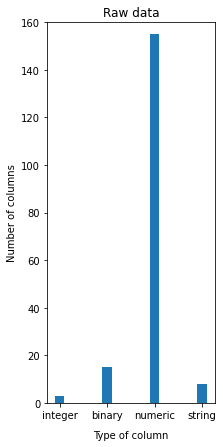

In [6]:
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.xlabel('Type of column', labelpad=10)
plt.ylim(0, 160)
plt.ylabel('Number of columns')
plt.title('Raw data')

fig.show()        

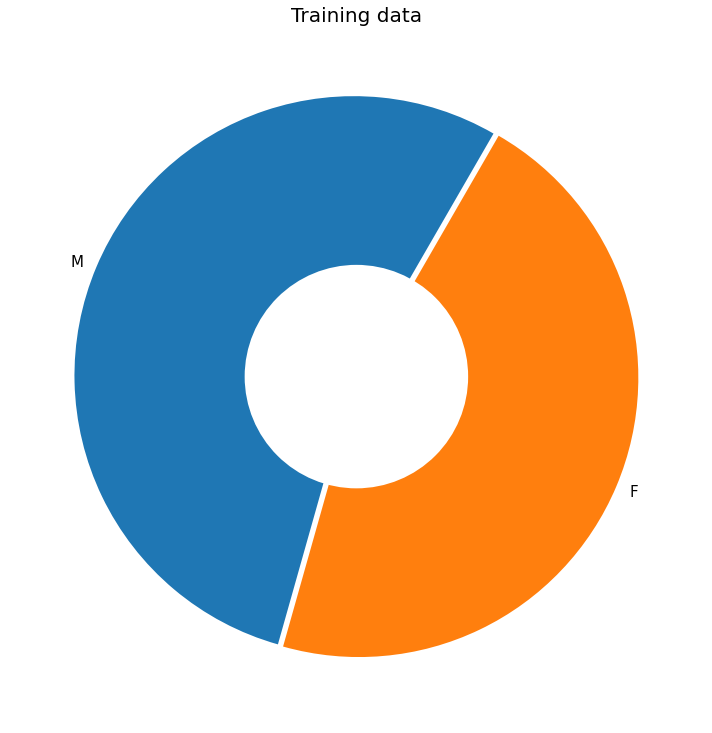

In [14]:
cat_variable = 'gender'

fig, ax  = plt.subplots(figsize=(10, 10))
labels = list(X_train[cat_variable].dropna().unique())
explode = (0.01, 0.01) 
#explode = (0.05, 0.05, 0.05, 0.05, 0.2, 0.3)
sizes = X_train[cat_variable].value_counts()
ax.pie(sizes, explode=explode, startangle=60, labels=labels, 
#autopct='%1.1f%%', pctdistance=0.6,
textprops={'fontsize': 15}, labeldistance=1.05) 
ax.add_artist(plt.Circle((0,0), 0.4, fc='white'))
plt.tight_layout()
plt.title('Training data', size=20)
plt.show()

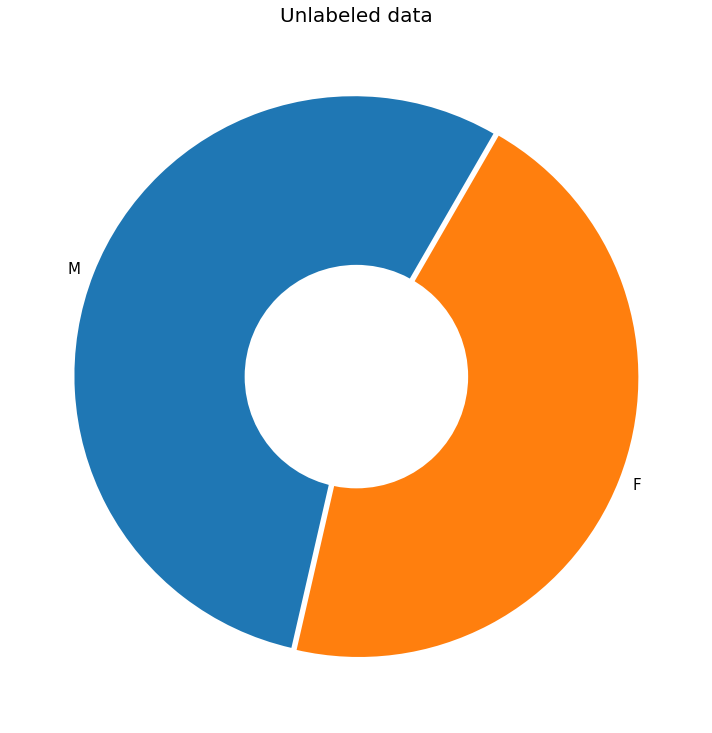

In [15]:
cat_variable = 'gender'

fig, ax  = plt.subplots(figsize=(10, 10))
labels = list(X_train[cat_variable].dropna().unique())
explode = (0.01, 0.01) 
#explode = (0.05, 0.05, 0.05, 0.05, 0.2, 0.3)
sizes = unlabeled[cat_variable].value_counts()
ax.pie(sizes, explode=explode, startangle=60, labels=labels, 
#autopct='%1.1f%%', pctdistance=0.6,
textprops={'fontsize': 15}, labeldistance=1.05) 
ax.add_artist(plt.Circle((0,0), 0.4, fc='white'))
plt.tight_layout()
plt.title('Unlabeled data', size=20)
plt.show()

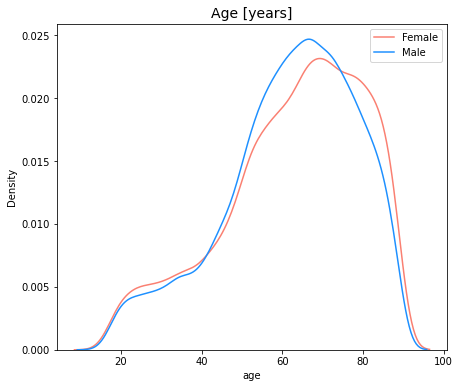

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].age, label='Female', color='salmon', bw_adjust=1.2, legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].age, label='Male', color='dodgerblue', bw_adjust=1.2, legend=True)
ax.set_title('Age [years]', fontsize=14)

plt.legend()
plt.show()

In [16]:
# impute height and weight with average values assuming that males are taller and heavier than females
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 160, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 180, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 170, X_train["height"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 65, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 82, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 74, X_train["weight"])

unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 160, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 180, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 170, unlabeled["height"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 65, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 82, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 74, unlabeled["weight"])

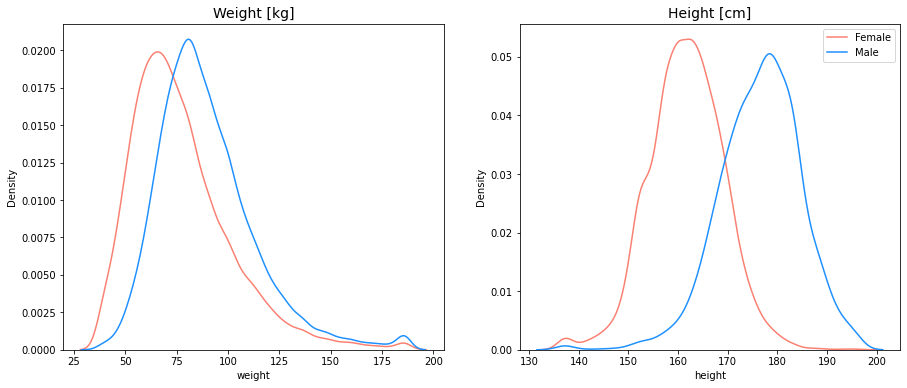

In [15]:
# Check that the distribution of height and weight in the data is approximately normal
# Plot univariate or bivariate distributions using kernel density estimation.
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations 
# in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density 
# curve in one or more dimensions.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0], bw_adjust=1.2,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0], bw_adjust=1.2,
legend=True)
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(X_train[X_train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1], bw_adjust=1.8,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1], bw_adjust=2,
legend=True)
ax[1].set_title('Height [cm]', fontsize=14)
plt.legend()
plt.show()

In [17]:
# find the number of missing values in each column and divide by column length
lst = X_train.isna().sum() / len(X_train)

# create a dataframe containing the percentage of missing values in each column
p = pd.DataFrame(lst)

# When we reset the index, the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

# find columns containing more than 30% missing values
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.3]
todelete = low_count['a'].values

# drop columns containing more than 30% missing values from the training and unlabeled datasets
X_train.drop(todelete, axis=1, inplace=True)
unlabeled.drop(todelete, axis=1, inplace=True)

print(X_train.shape)
print(unlabeled.shape)

(91713, 107)
(39308, 107)


<ipython-input-18-c8f8ec34791a>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


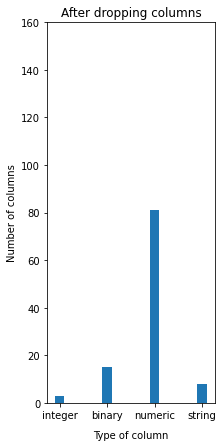

In [18]:
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.ylim(0, 160)
plt.xlabel('Type of column', labelpad=10)
plt.ylabel('Number of columns')
plt.title('After dropping columns')

fig.show() 

In [19]:
# drop rows ontaining more than 30% missing values from the training dataset
X_train.dropna(thresh=X_train.shape[1]*0.3, inplace=True)
X_train.shape

(91677, 107)

In [20]:
# for string columns, replace empty boxes with "None"
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name].where(pd.notnull(X_train[col_name]), None, inplace=True)

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name].where(pd.notnull(unlabeled[col_name]), None, inplace=True)

In [21]:
# encode string columns as integers
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name] = enc.fit_transform(X_train[[col_name]])

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name] = enc.fit_transform(unlabeled[[col_name]])

In [22]:
# convert the data types of all columns to float 
X_train = X_train.astype('float32')
unlabeled = unlabeled.astype('float32')

print(X_train.shape)
print(unlabeled.shape)

(91677, 107)
(39308, 107)


In [23]:
# impute missing values using k nearest neighbors where k=5
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', metric='nan_euclidean', 
copy=False)

knn_imputer.fit(X_train)

KNNImputer(copy=False, weights='distance')

In [24]:
# after fitting the imputer on the training set only, transform the training and unlabeled sets
knn_imputer.transform(X_train)

array([[ 0.      , 68.      , 22.73    , ...,  0.      ,  9.      ,
         0.      ],
       [ 0.      , 77.      , 27.42    , ...,  0.      ,  8.      ,
         6.      ],
       [ 0.      , 25.      , 31.95    , ...,  0.      ,  5.      ,
         3.      ],
       ...,
       [ 0.      , 48.      , 27.236914, ...,  0.      ,  5.      ,
         3.      ],
       [ 0.      , 78.084366, 23.297482, ...,  0.      ,  8.      ,
         6.      ],
       [ 0.      , 82.      , 22.03125 , ...,  0.      ,  1.      ,
         1.      ]], dtype=float32)

In [25]:
knn_imputer.transform(unlabeled)

array([[ 0.        , 56.        , 21.10244   , ...,  0.        ,
         7.        ,  4.        ],
       [ 0.        , 59.110256  , 19.500595  , ...,  0.        ,
         7.        ,  4.        ],
       [ 0.        , 66.        , 32.518597  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , 71.        , 23.01038   , ...,  1.        ,
         9.        ,  0.        ],
       [ 0.        , 57.        , 32.98795   , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19734402, 66.        , 23.183392  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [26]:
# save the processed data as csv files
X_train.to_pickle("X_train_knn.csv")
unlabeled.to_pickle("unlabeled_knn.csv")

In [2]:
# read the processed data from csv files
X_train = pd.read_pickle("X_train_knn.csv")
unlabeled = pd.read_pickle("unlabeled_knn.csv")

In [6]:
# create a list of numeric columns names 
num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

In [7]:
# create correlation matrix of numeric columns 
corr_matrix = X_train[num_feature].corr().abs()

<AxesSubplot:>

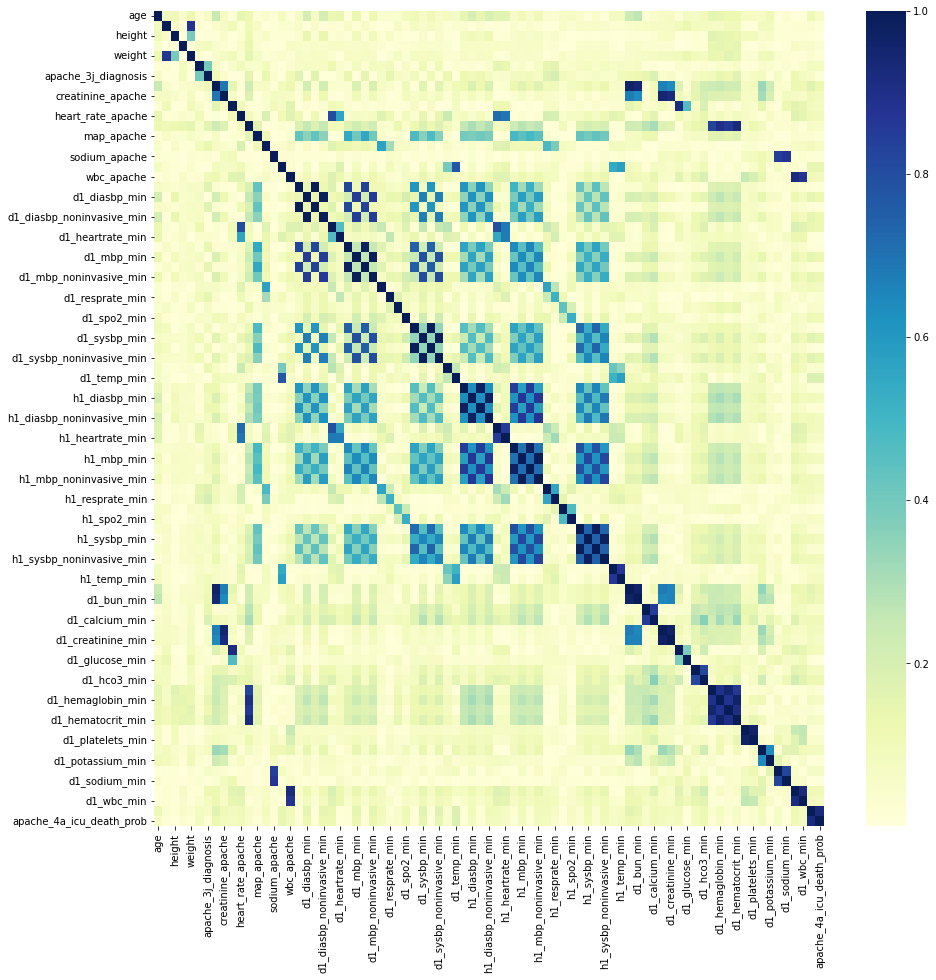

In [8]:
# create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [9]:
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

Text(0, 0.5, 'number of columns to drop')

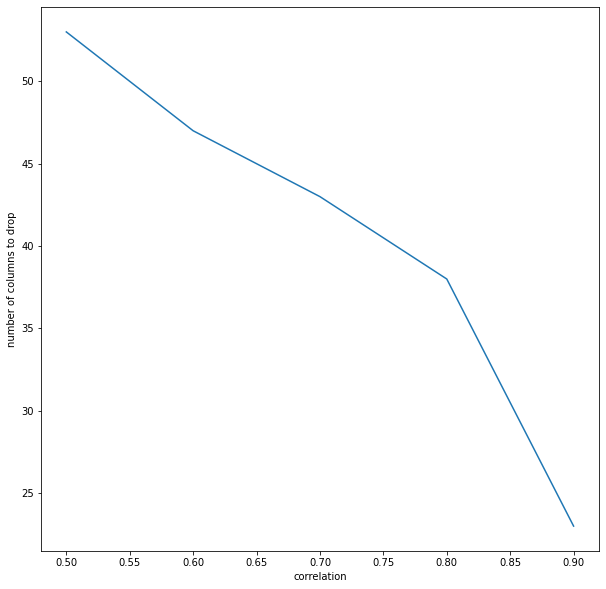

In [10]:
# plot a graph of number of columns to drop vs correlation
corr = []
to_drop_columns = []

for i in np.arange(0.5, 1, 0.1):
    to_drop = [column for column in upper.columns if any(upper[column] > i)]
    corr.append(i)
    to_drop_columns.append(len(to_drop))

plt.subplots(figsize=(10, 10))
plt.plot(corr, to_drop_columns)
plt.xlabel('correlation')
plt.ylabel('number of columns to drop')

In [11]:
# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# drop columns that have more than 80% correlation to other columns
X_train.drop(to_drop, inplace=True, axis=1)
unlabeled.drop(to_drop, inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91677, 69)
(39308, 69)


In [12]:
# remove outliers using isolation forest algorithm
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=1000, max_samples=1000, contamination='auto', max_features=10, 
bootstrap=False, n_jobs=-1, random_state=20)

yhat = iso.fit_predict(X_train)

scores = iso.decision_function(X_train)

# select all rows that are not outliers
mask = yhat != -1

np.unique(mask, return_counts=True)

(array([False,  True]), array([ 2086, 89591], dtype=int64))

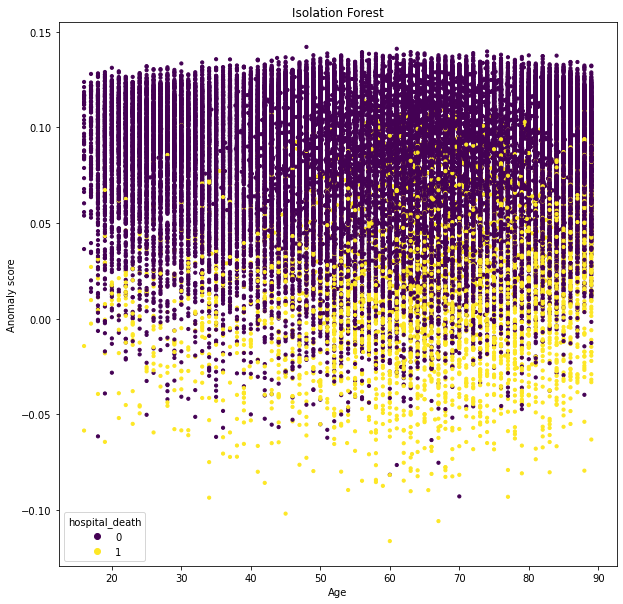

In [13]:
plt.subplots(figsize=(10, 10))
plt.title("Isolation Forest")

b = plt.scatter(X_train['age'], scores, c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('Age')
plt.ylabel('Anomaly score')
plt.show()

In [14]:
# drop outlier samples from the training dataset
X_train = X_train.loc[mask]

In [15]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

scalar.fit(X_train)

X_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
unlabeled_scaled = pd.DataFrame(scalar.transform(unlabeled), columns=unlabeled.columns)

In [16]:
X_train_scaled.to_pickle("X_train_scaled.csv")
unlabeled_scaled.to_pickle("unlabeled_scaled.csv")

In [ ]:
X_train_scaled = pd.read_pickle("X_train_scaled.csv")
unlabeled_scaled = pd.read_pickle("unlabeled_scaled.csv")

In [17]:
from sklearn.decomposition import PCA

pca = PCA(random_state=20)
components = pca.fit_transform(X_train_scaled)

<ipython-input-18-904d8f0ed3f6>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


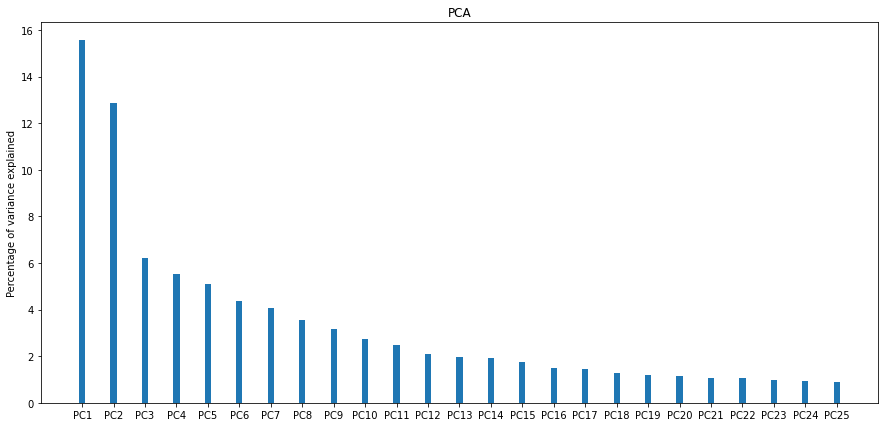

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar([f"PC{i+1}" for i in range(25)], pca.explained_variance_ratio_[0:25]*100, width=0.2)
plt.ylabel('Percentage of variance explained')
plt.title('PCA')

fig.show()

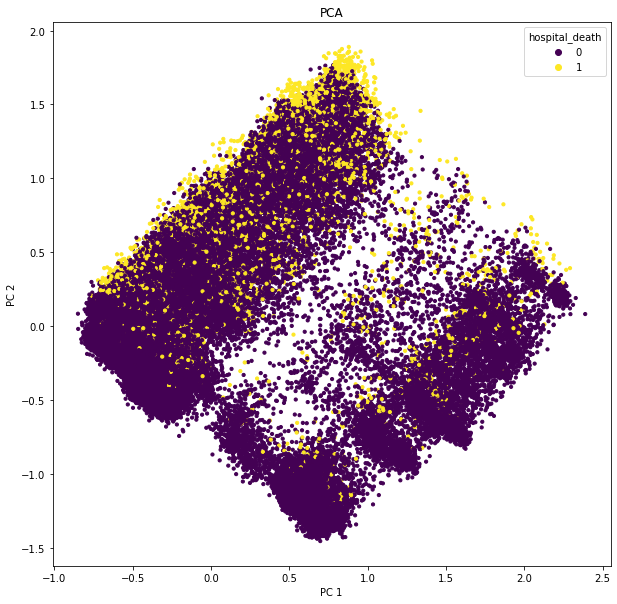

In [19]:
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

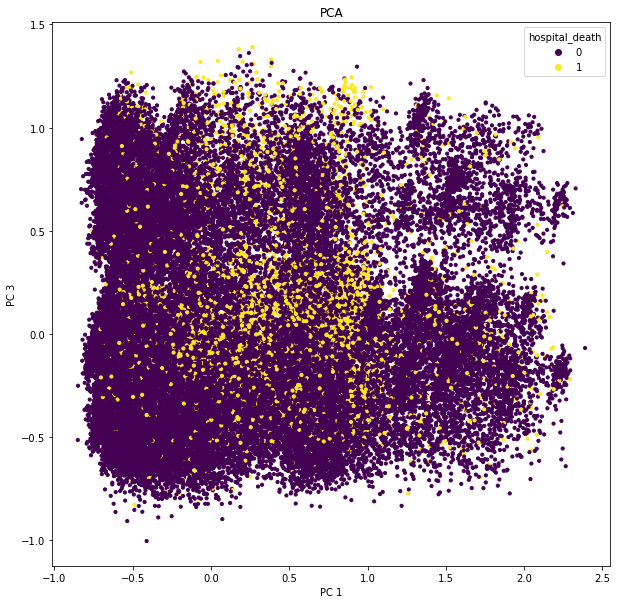

In [20]:
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,2], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.show()

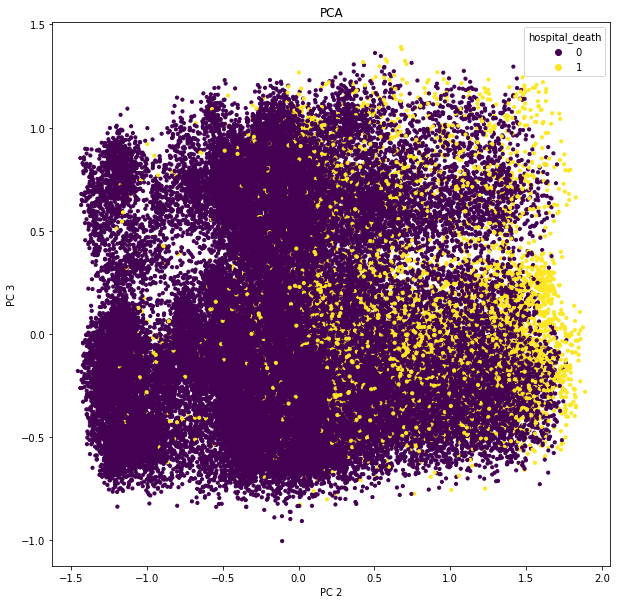

In [21]:
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,1], components[:,2], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.show()

In [22]:
# extract the column containing labels from the training dataset and store it separately as a vector
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)

In [23]:
unlabeled.drop('hospital_death', inplace=True, axis=1)

In [24]:
y_train.value_counts() / len(y_train)

0.0    0.927638
1.0    0.072362
Name: hospital_death, dtype: float64

In [25]:
cat_feature = []

for i, col_name in enumerate(X_train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [26]:
from sklearn.model_selection import train_test_split

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, 
random_state=20)
X_train11, X_train21, y_train11, y_train21 = train_test_split(X_train1, y_train1, test_size=0.5, 
stratify=y_train1, random_state=20)
X_train12, X_train22, y_train12, y_train22 = train_test_split(X_train2, y_train2, test_size=0.5, 
stratify=y_train2, random_state=20)
X_train111, X_train211, y_train111, y_train211 = train_test_split(X_train11, y_train11, test_size=0.5, 
stratify=y_train11, random_state=20)
X_train121, X_train221, y_train121, y_train221 = train_test_split(X_train21, y_train21, test_size=0.5, 
stratify=y_train21, random_state=20)
X_train112, X_train212, y_train112, y_train212 = train_test_split(X_train12, y_train12, test_size=0.5, 
stratify=y_train12, random_state=20)
X_train122, X_train222, y_train122, y_train222 = train_test_split(X_train22, y_train22, test_size=0.5, 
stratify=y_train22, random_state=20)

In [27]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=cat_feature, n_jobs=-1, random_state=20)

X_train111, y_train111 = sm.fit_resample(X_train111, y_train111)

In [28]:
X_train211, y_train211 = sm.fit_resample(X_train211, y_train211)

In [29]:
X_train121, y_train121 = sm.fit_resample(X_train121, y_train121)

In [30]:
X_train221, y_train221 = sm.fit_resample(X_train221, y_train221)

In [31]:
X_train112, y_train112 = sm.fit_resample(X_train112, y_train112)

In [32]:
X_train212, y_train212 = sm.fit_resample(X_train212, y_train212)

In [33]:
X_train122, y_train122 = sm.fit_resample(X_train122, y_train122)

In [34]:
X_train222, y_train222 = sm.fit_resample(X_train222, y_train222)

In [35]:
print(y_train111.value_counts() / len(y_train111))
print(y_train211.value_counts() / len(y_train211))
print(y_train121.value_counts() / len(y_train121))
print(y_train221.value_counts() / len(y_train221))
print(y_train112.value_counts() / len(y_train112))
print(y_train212.value_counts() / len(y_train212))
print(y_train122.value_counts() / len(y_train122))
print(y_train222.value_counts() / len(y_train222))

0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64


In [36]:
X_train = pd.concat([X_train111, X_train211, X_train121, X_train221, 
X_train112, X_train212, X_train122, X_train222])
y_train = pd.concat([y_train111, y_train211, y_train121, y_train221, 
y_train112, y_train212, y_train122, y_train222])

print(X_train.shape)
print(y_train.shape)

(166216, 68)
(166216,)


In [32]:
X_train.to_pickle("X_train_smote.csv")
unlabeled.to_pickle("unlabeled_smote.csv")
y_train.to_pickle("y_train_smote.csv")

In [ ]:
X_train = pd.read_pickle("X_train_smote.csv")
y_train = pd.read_pickle("y_train_smote.csv")
unlabeled = pd.read_pickle("unlabeled_smote.csv")

In [41]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(random_state=20)

n_estimators = [1500]

min_samples_split = [20, 50, 100]

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', 
error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a Random Forest model using the optimal parameter values obtained from the grid search
RF_classifier = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                min_samples_split=grid_result.best_params_['min_samples_split'],
                random_state=20)

Best: 0.902262 using {'min_samples_split': 20, 'n_estimators': 1500}


In [42]:
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=1500, random_state=20)

In [43]:
sorted_idx = RF_classifier.feature_importances_.argsort()

Text(0.5, 0, 'Random Forest Feature Importance')

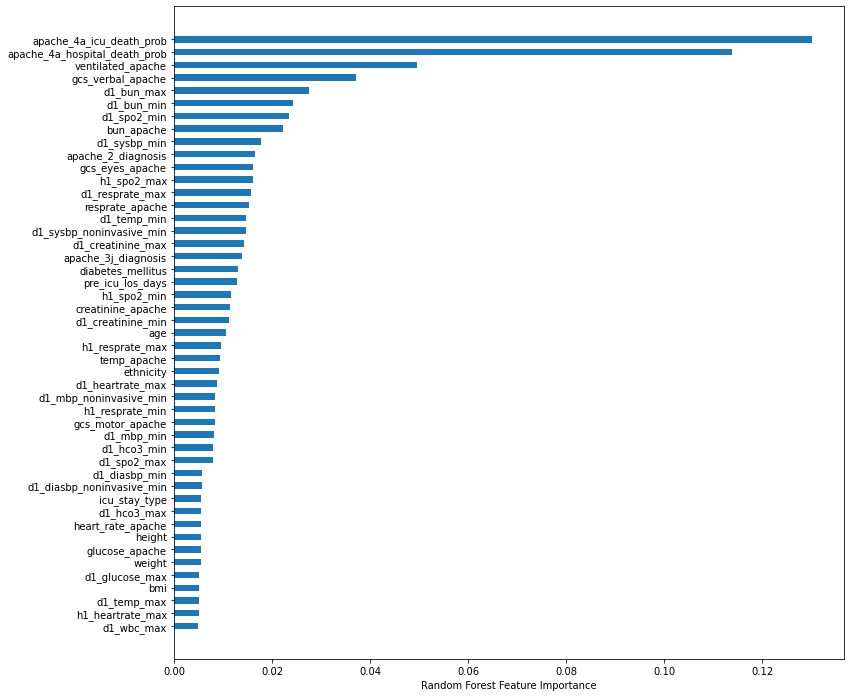

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.barh(X_train.columns[sorted_idx[60:107]], RF_classifier.feature_importances_[sorted_idx[60:107]], 
height=0.5)
plt.xlabel("Random Forest Feature Importance")

In [ ]:
from sklearn.metrics import accuracy_score

pred = RF_classifier.predict(X_test)
print(f"accuracy score voting is {accuracy_score(y_test, pred)}")

In [62]:
prob = RF_classifier.predict_proba(unlabeled)[:,1]

submission = pd.DataFrame({'encounter_id': unlabeled['encounter_id'].astype(int), 'hospital_death': prob})

print(len(prob))
print(len(unlabeled['encounter_id']))

39308
39308


In [63]:
submission.to_csv("submission.csv", index=False)